<h1> ______________________________________ </h1>

<h1> Full NEXT100 with fiber panels simulation mapping analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we analyse the results from the MC decays of Kr38m and bb0nu events simulated in a "realistic" fiber barrel. A mapping of the signal depending on the spatial position is perfomed in the XY plane and Z-axis and then used to determine the energy resolution at Krypton's decay energy. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 100 Kr38m S1 events. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

<h1> _________________________________________________________________________________________________________ </h1>


<h1> __________________________ </h1>
<h2> Functions </h2>

-  <p style="font-size: 17px; color: black;"> <b> gauss(x, a,  mu, sigma): </b> Gaussian normalized to $a$. </p>


-  <p style="font-size: 17px; color: black;"> <b> gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1): </b> Sum of 2 gaussians. </p>


-  <p style="font-size: 17px; color: black;"> <b> dirac(x, x0): </b> Dirac delta at $x0$. </p>




In [2]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    
    gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
    
    return (a/gaussian.sum())*gaussian

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

def dirac(x, x0):
    return np.where((x - x0) == 0, 1, 0)


<h1> __________________________ </h1>
<h2> Global parameters </h2>

-  <p style="font-size: 17px; color: black;"> <b> Pandas dataset params: </b> Allows to set the max number of columns and rows that are shown in a pandas dataset. </p>

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 20)

-  <p style="font-size: 17px; color: black;"> <b> Plots params: </b> In case you want to fix the parameters for all plots. </p>

In [4]:
# plt.rcParams["figure.figsize"] = 10, 8
# plt.rcParams["font.size"] = 10

-  <p style="font-size: 17px; color: black;"> <b> Analysis parameters </b> </p>



In [5]:
dark25 = 2000 # [Kcps] (1Kcps = 1e3 dark pulses per second) DCR at 25ºC
x_talk = 7 # [%] Probability of a dark count to be 2pe instead of 1pe
n_sensors = 90 
t_binning = 0.1 # [ns] Conversion constant from bin enumerations to nanoseconds (binning used in the simulation)
dT = 5.3 # [ºC] Decay factor at which the dark rate halves

<h1> __________________________ </h1>
<h2> Data </h2>

-  <p style="font-size: 17px; color: black;"> <b> Reading the file </b> </p>

-  <p style="font-size: 17px; color: black;"> File's path </p>

In [6]:
path = '/home/investigator/mariandbt/nexus'
filename = os.path.join(path, "Next100_full.next.h5")

# path = '/home/investigator/mariandbt/python/data/'
# # path = path + '/20230921_NEXT100_full_fiber_barrel'
# path = path + '/20231025_NEXT100_full_mapping'

# filename = os.path.join(path, "Next100_full_Kr_noEL_10Kev.next.h5")

# filename = os.path.join(path, "Next100_full_Kr_noEL_100ev.next.h5")
# filename = os.path.join(path, "Next100_full_Kr_1event.next.h5")
# filename = os.path.join(path, "Next100_full_Kr_noEL_100ev.next.h5")
# filename = os.path.join(path, "Next100_full_Kr_noEL_100ev_sensName.next.h5")
# filename = os.path.join(path, "Next100_full_Kr_noEL_20ev.next.h5")


-  <p style="font-size: 17px; color: black;"> In a .h5 file there are several objects, so we print them all to then pick the one we're interested in </p>

In [7]:
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/python/data//20231025_NEXT100_full_mapping/Next100_full_Kr_noEL_10Kev.next.h5 (File) ''
Last modif.: '2023-10-25T04:10:45+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(39,)) ''
/MC/hits (Table(673964,)) ''
/MC/particles (Table(51361,)) ''
/MC/sns_positions (Table(3166,)) ''
/MC/sns_response (Table(237316,)) ''



-  <p style="font-size: 17px; color: black;"> Read the file and make a copy to work with, this way it's easier to re-start the copy instead of re-reading the file. </p>

In [8]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
particles = pd.read_hdf(filename, "/MC/particles")
sensors = pd.read_hdf(filename, "/MC/sns_positions")
data = pd.read_hdf(filename, "/MC/sns_response")


In [9]:
dst_particle = particles.copy()
sens = sensors.copy()
dst = data.copy()


<h1> __________________________ </h1>
<h2> Analysis </h2>

In [10]:
dst.time_bin = dst.time_bin*t_binning # change units to ns

In [11]:
n_events = dst.event_id.max() + 1 # save number of events simulated

# *** OJO AQUII!!

In [12]:
sens_mask = sens.loc[sens.sensor_name == 'F_SENSOR'].sensor_id

dst = dst.loc[dst.sensor_id.isin(sens_mask)]

# *** 

In [13]:
fiber_sens_mask = sens.loc[sens.sensor_name == 'F_SENSOR'].sensor_id # ID mask of the sensors at the end of the fibers

dst_fibers = dst.loc[dst.sensor_id.isin(fiber_sens_mask)] # dst only for the sensor on the fibers


In [14]:
event_charge = dst_fibers.groupby("event_id").charge.sum() # total charge detected on each event

- <p style="font-size: 17px; color: black;"> <b> Save the coordinates of each event: </b> Since the initial coordinates are the same for all primary particles in the event we need to only save the 1st. </p>

In [15]:
# dst_particle

In [16]:
ev_x0 = dst_particle.loc[dst_particle.primary == 1].groupby("event_id").initial_x.first()
ev_y0 = dst_particle.loc[dst_particle.primary == 1].groupby("event_id").initial_y.first()
ev_z0 = dst_particle.loc[dst_particle.primary == 1].groupby("event_id").initial_z.first()

- <p style="font-size: 17px; color: black;"> <b> Map the charge vs positon hists: </b> Map in XY with a 2D histogram and in Z-axis with a 1D histogram. </p>

/tmp/ipykernel_333255/3767049243.py:20: RuntimeWarning: invalid value encountered in true_divide
  hist_norm = np.where(hist_counts > 0., np.divide(hist, hist_counts), 0.)


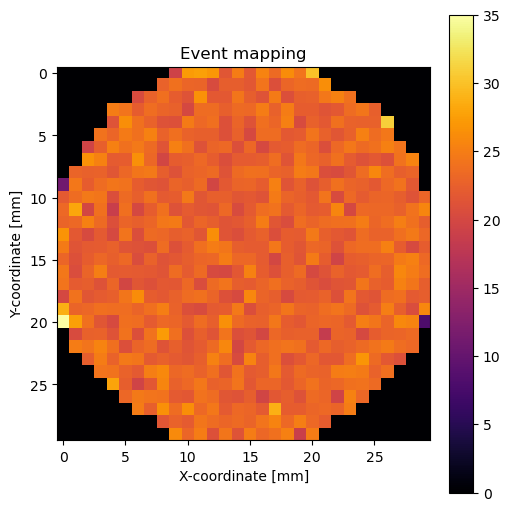

In [51]:
# XY-plane
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

# n_bins = int(np.sqrt(n_events))
n_bins = 30
font_size = 8.5

# Create a 2D histogram
hist, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
                                      bins=(n_bins, n_bins), 
                                      weights = event_charge,
                                      density=False)

hist_counts, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
                                             bins=(n_bins, n_bins), 
                                             density=False)

# Calculate the mean values in each bin (normalized histogram)
hist_norm = np.where(hist_counts > 0., hist / hist_counts, 0.)


plt.imshow(hist_norm, cmap='inferno')
plt.colorbar()
plt.xlabel('X-coordinate [mm]')
plt.ylabel('Y-coordinate [mm]')
plt.title('Event mapping')
ax.set_aspect("equal") 


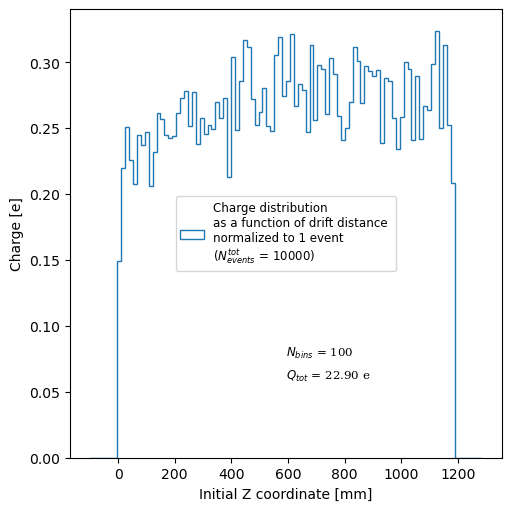

In [18]:
# Z_axis
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

n_bins = int(np.sqrt(n_events))
font_size = 8.5

events, bins, bars = ax.hist(ev_z0, n_bins, 
                             weights = event_charge/n_events,
                             density=False,
                             range=(ev_z0.min() - 100, ev_z0.max() + 100),
                             label='Charge distribution \nas a function of drift distance \nnormalized to 1 event \n($N^{tot}_{events}$ = %s)'%(n_events), 
                             histtype='step')

ax.text(0.5, .25, r'$N_{bins}$ = %s'%(n_bins), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.text(0.5, .2, r'$Q_{tot}$ = %.2f e'%(events.sum()), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.set_ylabel('Charge [e]')
ax.set_xlabel('Initial Z coordinate [mm]')
ax.legend(fontsize = font_size, loc = 'center');


- <p style="font-size: 17px; color: black;"> <b> Energy resolution: </b> . </p>

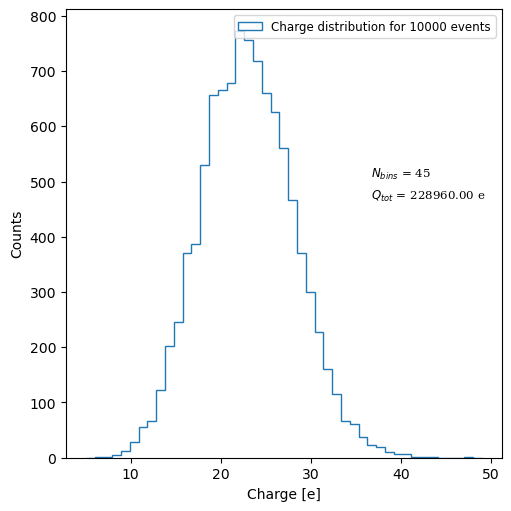

In [29]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

# n_bins = int(np.sqrt(len(event_charge)))
n_bins = 45
font_size = 8.5

events, bins, bars = ax.hist(event_charge, n_bins, 
                             density=False,
                             range=(event_charge.min() - 1, event_charge.max() + 1),
                             label=f'Charge distribution for {n_events} events', 
                             histtype='step')

ax.text(0.7, .65, r'$N_{bins}$ = %s'%(n_bins), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.text(0.7, .6, r'$Q_{tot}$ = %.2f e'%(event_charge.sum()), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.set_xlabel('Charge [e]')
ax.set_ylabel('Counts')
ax.legend(fontsize = font_size);
